In [189]:
import nibabel as nib
import numpy as np 
import os
import tensorflow as tf

In [191]:
X_train.shape

TensorShape([33, 128, 128, 128])

In [190]:
def load_nifti_image(filepath):
    img=nib.load(filepath)
    return img.get_fdata()

In [3]:
from scipy.ndimage import zoom

def preprocess_image_3d(image):
    # Compute the zoom factors for each dimension (z, y, x)
    zoom_factors = [128 / s for s in image.shape]  # Assumes input is a 3D array (z, y, x)
    
    # Resize the 3D image using zoom
    image = zoom(image, zoom_factors, order=1)  # Order=1 for bilinear interpolation
    
    # Normalize the image (assuming non-zero max)
    image = image / np.max(image) if np.max(image) != 0 else image
    
    return image


In [4]:
import os
import numpy as np

def load_3d_data(image_dir):
    X = []
    y = []
    
    # Get the list of filenames from each modality folder (assuming they are the same across folders)
    flair_files = sorted(os.listdir(os.path.join(image_dir, 'flair')))
    pd_files = sorted(os.listdir(os.path.join(image_dir, 'pd')))
    t1_files = sorted(os.listdir(os.path.join(image_dir, 't1')))
    t2_files = sorted(os.listdir(os.path.join(image_dir, 't2')))
    gt_files = sorted(os.listdir(os.path.join(image_dir, 'gt')))
    
    # Check that all folders have the same number of files (ignoring t1ce if you're only using 4 modalities)
    if not (len(flair_files) == len(pd_files) == len(t1_files) == len(t2_files) == len(gt_files)):
        print("Mismatch in number of files between modality folders!")
        return None, None

    # Loop over each file in the modality folders (ignoring t1ce)
    for flair_file, pd_file, t1_file, t2_file, gt_file in zip(flair_files, pd_files, t1_files, t2_files, gt_files):
        
        # Ensure files are valid (ignore hidden/system files like .DS_Store)
        if not flair_file.endswith('.nii.gz') or not pd_file.endswith('.nii.gz') or not t1_file.endswith('.nii.gz') or not t2_file.endswith('.nii.gz') or not gt_file.endswith('.nii.gz'):
            print(f"Skipping non-NIfTI file: {flair_file}")
            continue
        
        # Construct full file paths for each modality
        flair_path = os.path.join(image_dir, 'flair', flair_file)
        pd_path = os.path.join(image_dir, 'pd', pd_file)
        t1_path = os.path.join(image_dir, 't1', t1_file)
        t2_path = os.path.join(image_dir, 't2', t2_file)
        gt_path = os.path.join(image_dir, 'gt', gt_file)

        # Check if all modality files exist for this image
        if not all(os.path.exists(path) for path in [flair_path, pd_path, t1_path, t2_path, gt_path]):
            print(f"Missing files for: {flair_file}")
            continue

        # Load and preprocess each modality
        flair_image = preprocess_image_3d(load_nifti_image(flair_path))
        pd_image = preprocess_image_3d(load_nifti_image(pd_path))
        t1_image = preprocess_image_3d(load_nifti_image(t1_path))
        t2_image = preprocess_image_3d(load_nifti_image(t2_path))
        gt_image = preprocess_image_3d(load_nifti_image(gt_path))

        # Stack only 4 modalities together (flair, pd, t1, t2)
        input_image = np.stack([flair_image, pd_image, t1_image, t2_image], axis=-1)  # Now stacking 4 modalities, along the last axis
        X.append(flair_image)
        y.append(gt_image)

    return np.array(X), np.array(y)


In [40]:
X_train,y_train=load_3d_data('train')

In [41]:
X_train.shape


(33, 128, 128, 128)

In [42]:
y_train.shape

(33, 128, 128, 128)

In [181]:
def unet_3d(input_shape_mri):
    mri_inputs = layers.Input(shape=input_shape_mri, name='mri_input')

    def conv_block(x, filters):
        x = layers.Conv3D(filters, (3, 3, 3), padding='same')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Conv3D(filters, (3, 3, 3), padding='same')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        return x

    def encoder_block(x, filters):
        x = conv_block(x, filters)
        p = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
        return x, p

    def decoder_block(x, skip, filters):
        x = layers.UpSampling3D(size=(2, 2, 2))(x)
        x = layers.Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    # U-Net architecture with increased filters and depth
    skip1, pool1 = encoder_block(mri_inputs, 32)  # Increased filters
    skip2, pool2 = encoder_block(pool1, 64)
    skip3, pool3 = encoder_block(pool2, 128)
    bottleneck = conv_block(pool3, 256)  # Add more depth here
    up1 = decoder_block(bottleneck, skip3, 128)
    up2 = decoder_block(up1, skip2, 64)
    up3 = decoder_block(up2, skip1, 32)

    # Output layer
    outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(up3)

    model = models.Model(inputs=mri_inputs, outputs=outputs)
    return model


In [20]:
class_0_count = np.sum(y_train == 0)
class_1_count = np.sum(y_train == 1)

print(f"Class 0 (background) count: {class_0_count}")
print(f"Class 1 (foreground) count: {class_1_count}")

Class 0 (background) count: 68983535
Class 1 (foreground) count: 2330


In [242]:
print(f"X_train shape: {X_train.shape}")  
print(f"y_train shape: {y_train.shape}")
print(f"Model input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")

X_train shape: (33, 128, 128, 128)
y_train shape: (33, 128, 128, 128)
Model input shape: (None, 128, 128, 128, 1)
Model output shape: (None, 128, 128, 128, 1)


In [100]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for binary classification.
    gamma: focusing parameter
    alpha: balancing parameter
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = K.cast(y_true, tf.float32)

        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
        return loss
    return focal_loss_fixed


In [112]:
print(f"Unique values in y_train: {np.unique(y_train)}")


Unique values in y_train: [0.00000000e+00 1.70866483e-05 1.70866483e-05 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


In [113]:
y_train = np.where(y_train >= 0.5, 1, 0)
print(f"Unique values in y_train after binarization: {np.unique(y_train)}")


Unique values in y_train after binarization: [0 1]


In [244]:
class VisualizePredictionCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(X_train[:1])
        plt.imshow(predictions[0, :, :, 64, 0], cmap='gray')
        plt.title(f'Epoch {epoch + 1}')
        plt.show()

In [203]:
model=unet_3d(input_shape_mri,)

/home/raneem/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),  # Reduced learning rate
    loss=focal_loss(gamma=4., alpha=0.85),
    metrics=['accuracy']
)


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/stepaccuracy: 0.9814 - loss: 0.03


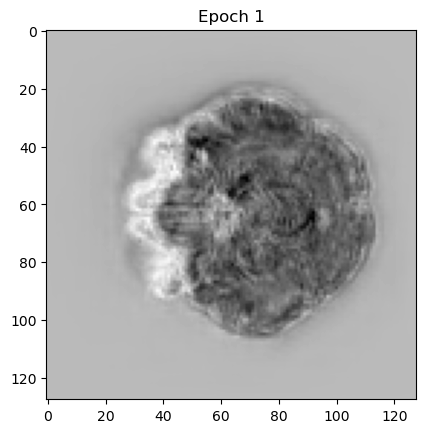

9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.9817 - loss: 0.0365
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step accuracy: 0.9882 - loss: 0.036


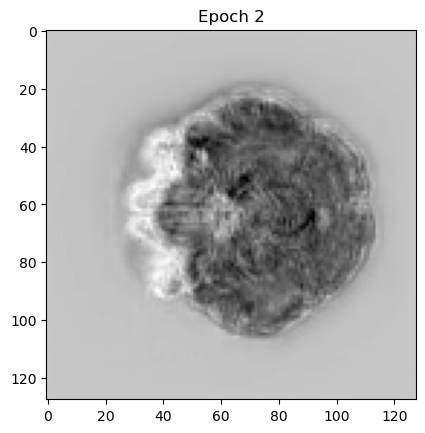

9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.9883 - loss: 0.0364
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step accuracy: 0.9915 - loss: 0.036


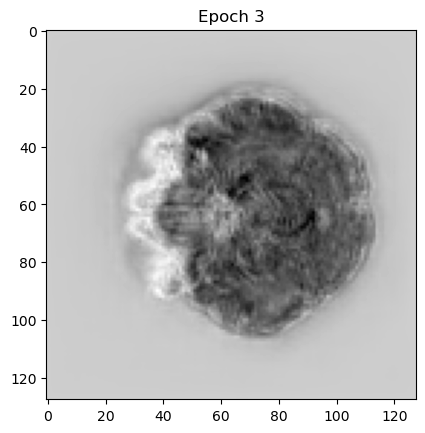

9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9915 - loss: 0.0363
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step accuracy: 0.9942 - loss: 0.036


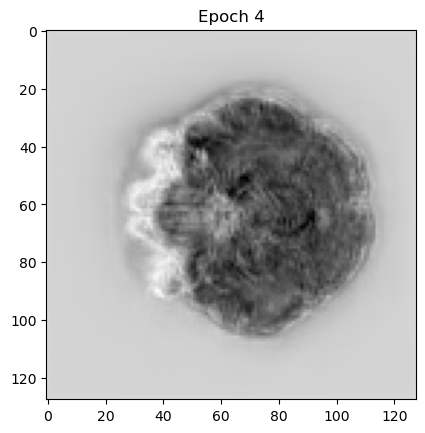

9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9942 - loss: 0.0361
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step accuracy: 0.9961 - loss: 0.036


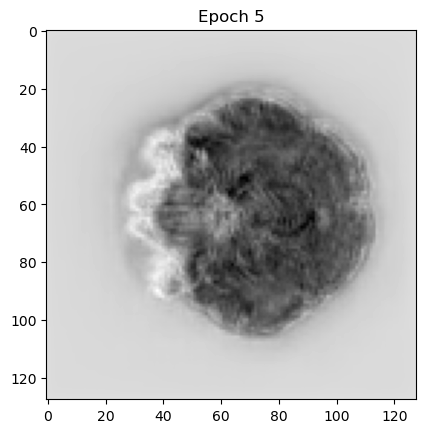

9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9961 - loss: 0.0360


In [205]:
model.fit(X_train, y_train, epochs=5, batch_size=4, callbacks=[VisualizePredictionCallback()])

In [213]:
prediction=model.predict(X_train[1:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


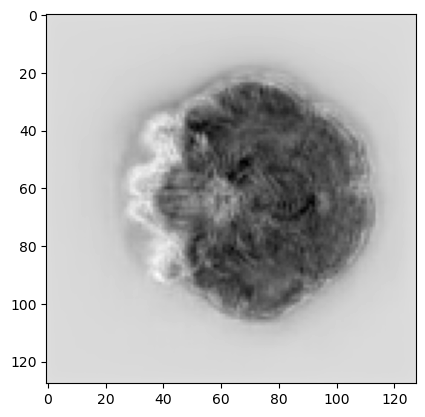

In [237]:
plt.imshow(prediction[0, :, :, 64, 0], cmap='gray')
plt.show()

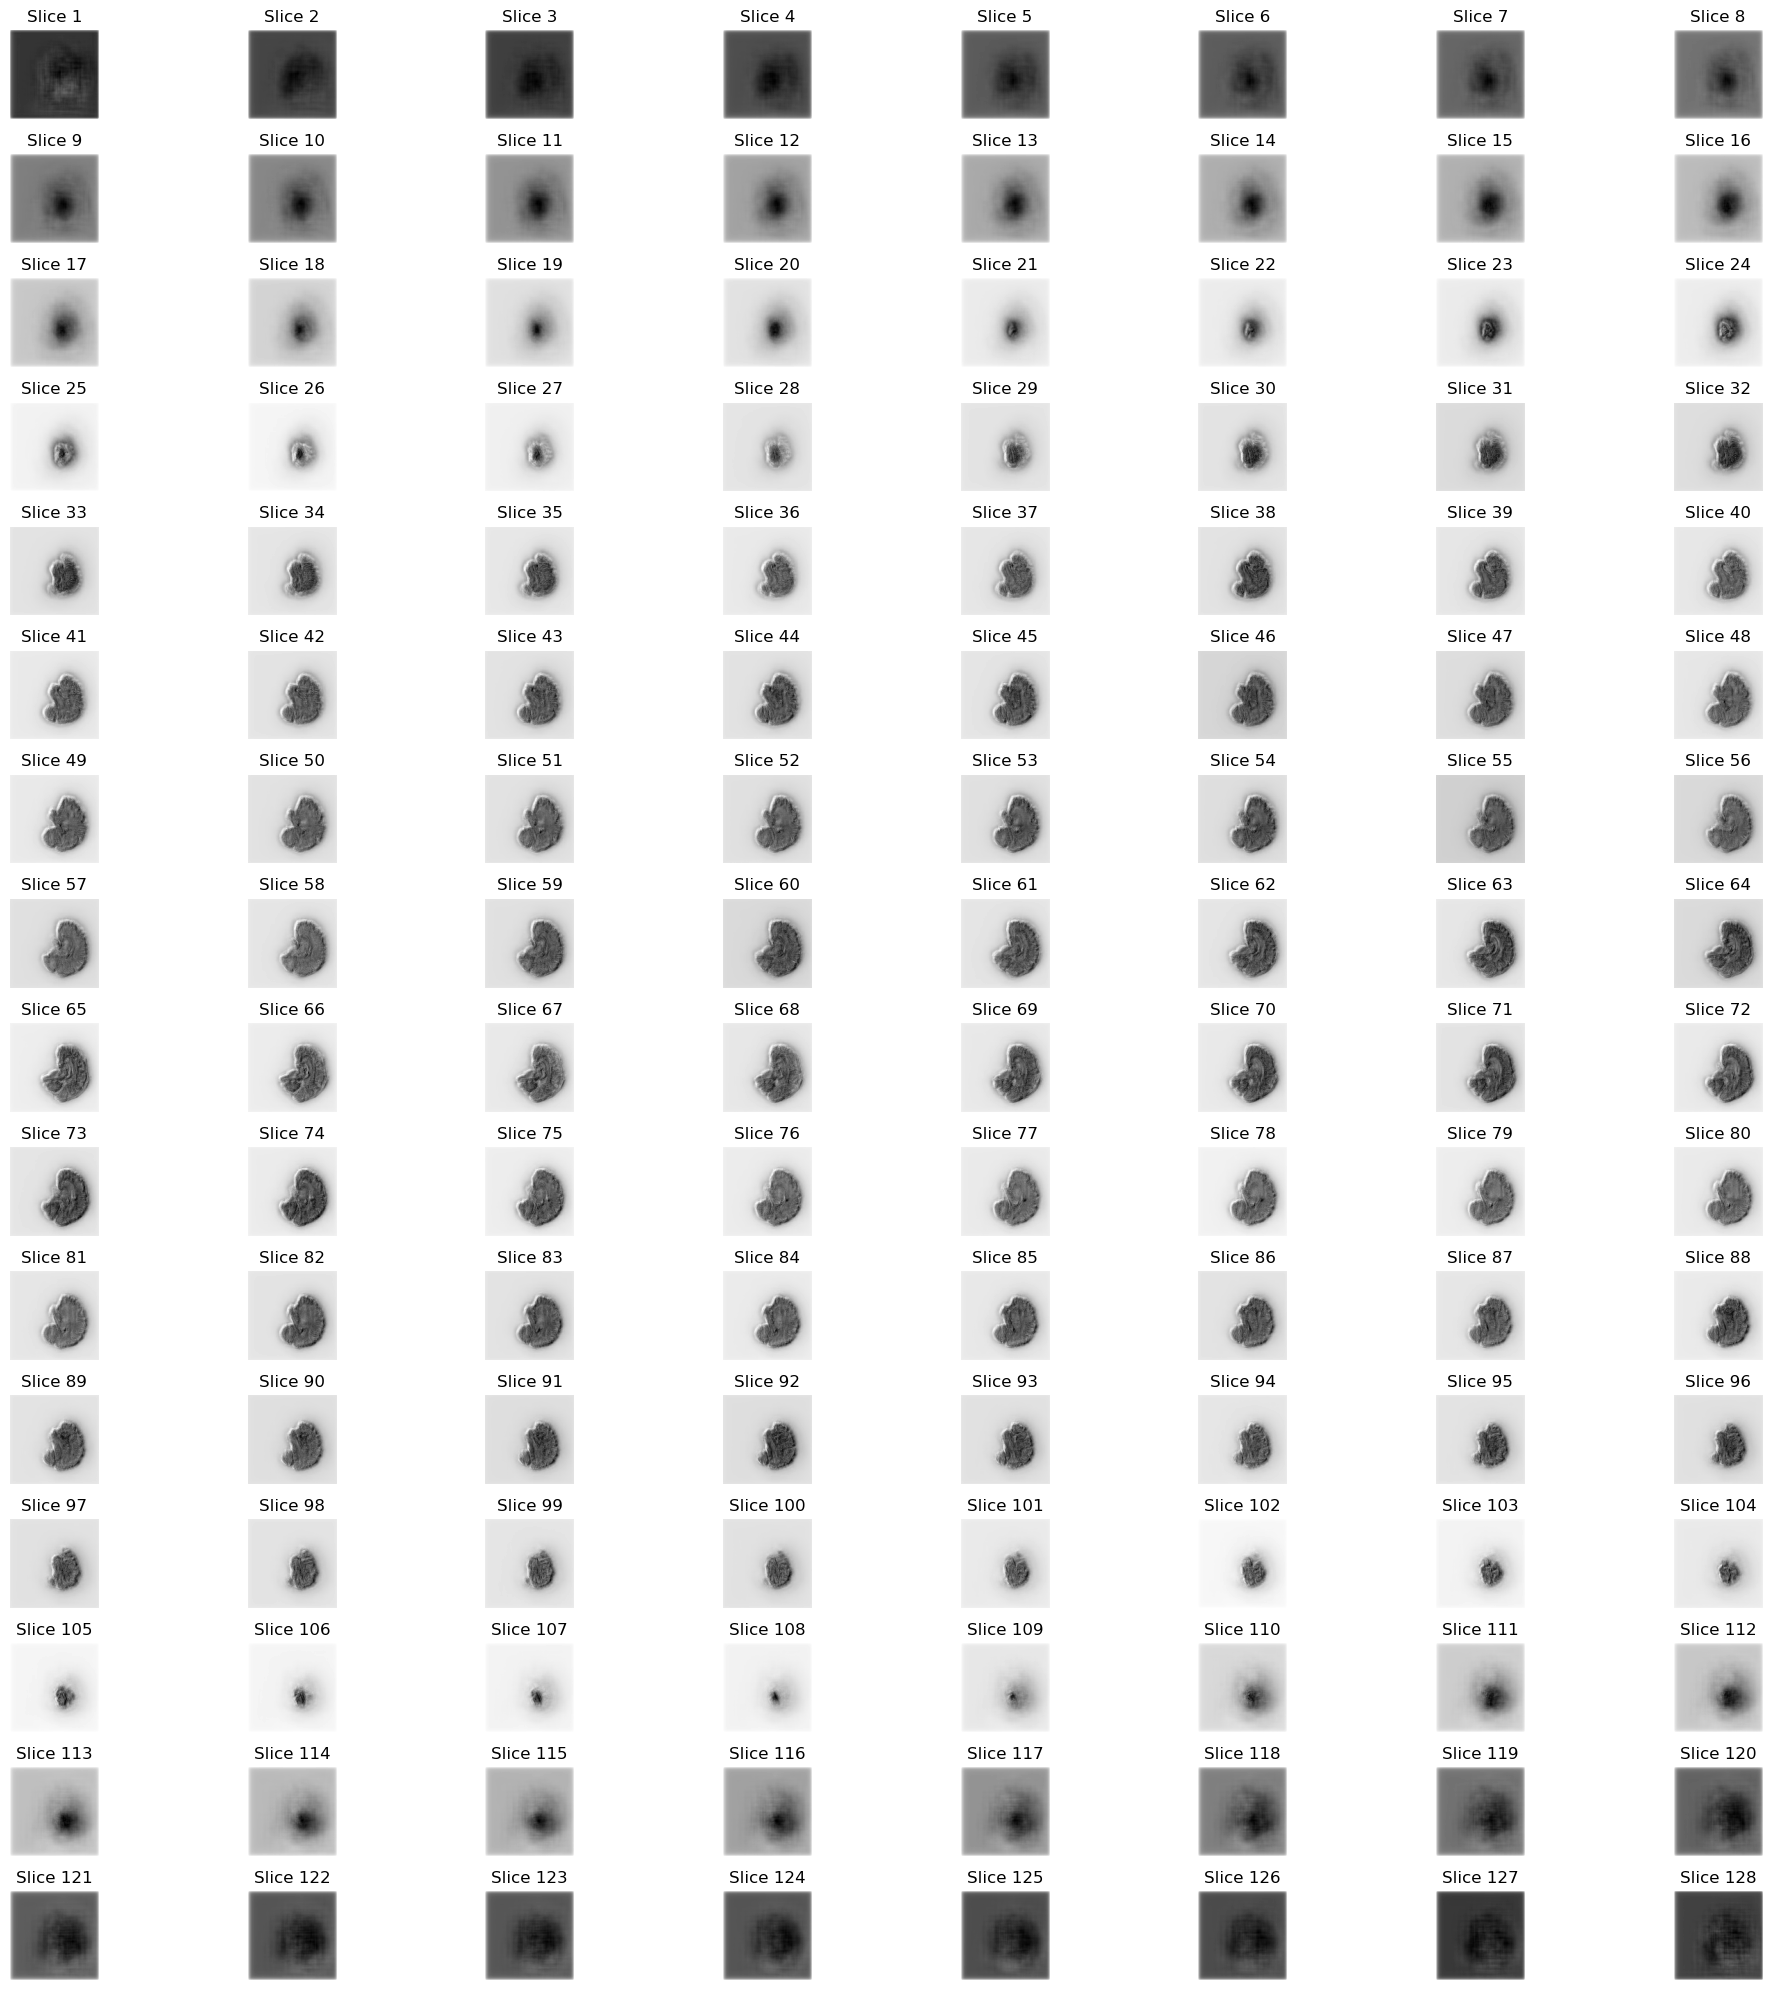

In [218]:
num_slices = prediction.shape[1]
fig, axes = plt.subplots(nrows=int(np.ceil(num_slices / 8)), ncols=8, figsize=(20, 20))  # Adjust rows and cols as needed
for i in range(num_slices):
    row = i // 8
    col = i % 8
    axes[row, col].imshow(prediction[0, i, :, :, 0], cmap='gray')
    axes[row, col].axis('off')  # Turn off axis labels for clarity
    axes[row, col].set_title(f"Slice {i+1}")
plt.tight_layout()
plt.show()

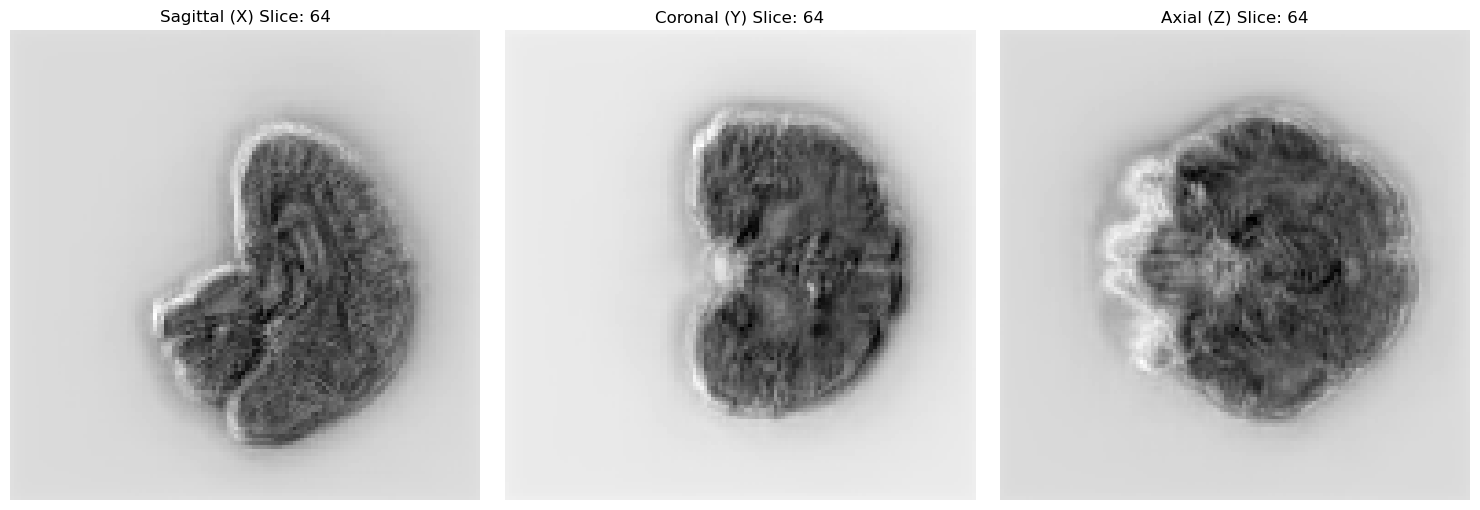

In [245]:
import matplotlib.pyplot as plt
volume = prediction[0, :, :, :, 0]
middle_x = volume.shape[0] // 2  
middle_y = volume.shape[1] // 2  
middle_z = volume.shape[2] // 2  
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(volume[middle_x, :, :], cmap='gray')
axes[0].set_title(f'Sagittal (X) Slice: {middle_x}')
axes[0].axis('off')
axes[1].imshow(volume[:, middle_y, :], cmap='gray')
axes[1].set_title(f'Coronal (Y) Slice: {middle_y}')
axes[1].axis('off')
axes[2].imshow(volume[:, :, middle_z], cmap='gray')
axes[2].set_title(f'Axial (Z) Slice: {middle_z}')
axes[2].axis('off')
plt.tight_layout()
plt.show()


In [221]:
model.save('model_with_mri.h5')


In [226]:
loaded_model = tf.keras.models.load_model('model_with_mri.h5', compile=False)


In [227]:
loaded_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mri_input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_75 (Conv3D)  │ (None, 128, 128,  │        896 │ mri_input[0][0]   │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_70      │ (None, 128, 128,  │          0 │ conv3d_75[0][0]   │
│ (LeakyReLU)         │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_76 (Conv3D)  │ (None, 128, 128,  │     27,680 │ leaky_re_lu_70[0… │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_71      │ (None, 128, 128,  │          0 │ conv3d_76[0][0]   │
│ (LeakyReLU)         │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_15    │ (None, 64, 64,    │          0 │ leaky_re_lu_71[0… │
│ (MaxPooling3D)      │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_77 (Conv3D)  │ (None, 64, 64,    │     55,360 │ max_pooling3d_15… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_72      │ (None, 64, 64,    │          0 │ conv3d_77[0][0]   │
│ (LeakyReLU)         │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_78 (Conv3D)  │ (None, 64, 64,    │    110,656 │ leaky_re_lu_72[0… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_73      │ (None, 64, 64,    │          0 │ conv3d_78[0][0]   │
│ (LeakyReLU)         │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_16    │ (None, 32, 32,    │          0 │ leaky_re_lu_73[0… │
│ (MaxPooling3D)      │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_79 (Conv3D)  │ (None, 32, 32,    │    221,312 │ max_pooling3d_16… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_74      │ (None, 32, 32,    │          0 │ conv3d_79[0][0]   │
│ (LeakyReLU)         │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_80 (Conv3D)  │ (None, 32, 32,    │    442,496 │ leaky_re_lu_74[0… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_75      │ (None, 32, 32,    │          0 │ conv3d_80[0][0]   │
│ (LeakyReLU)         │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_17    │ (None, 16, 16,    │          0 │ leaky_re_lu_75[0… │
│ (MaxPooling3D)      │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_81 (Conv3D)  │ (None, 16, 16,    │    884,992 │ max_pooling3d_17

 Total params: 5,836,033 (22.26 MB)

 Trainable params: 5,836,033 (22.26 MB)

 Non-trainable params: 0 (0.00 B)

In [246]:
prediction=loaded_model.predict(X_train[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


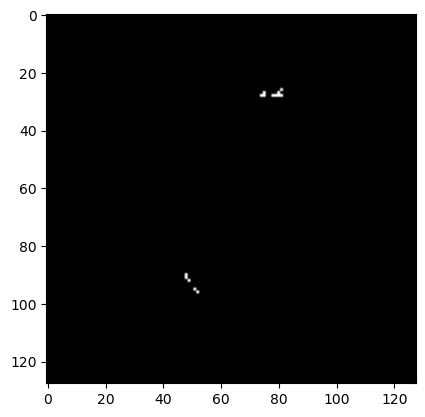

In [214]:
threshold = 0.5
binary_prediction = (prediction > threshold).astype(np.uint8)

# Visualize the thresholded output
plt.imshow(binary_prediction[0, :, :, 64, 0], cmap='gray')  # Slice at depth 64
plt.show()


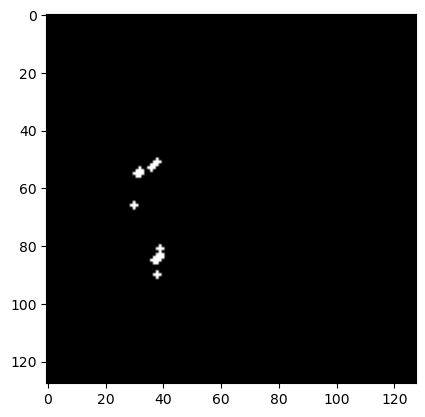

In [212]:
from scipy.ndimage import binary_erosion, binary_dilation
binary_erosion_prediction = binary_erosion(binary_prediction[0, :, :, 64, 0])
cleaned_prediction = binary_dilation(binary_erosion_prediction)
plt.imshow(cleaned_prediction, cmap='gray')
plt.show()


In [75]:
def resize_prediction_to_original_shape(prediction, original_shape):
    """
    Resize the predicted mask back to the original shape of the NIfTI image.
    
    Arguments:
    prediction -- Predicted class labels or segmentation mask
    original_shape -- The original shape of the NIfTI image
    
    Returns:
    resized_prediction -- The resized prediction mask
    """
    # Calculate the zoom factors to match the original shape
    zoom_factors = [o / p for o, p in zip(original_shape, prediction.shape)]
    
    # Resize the prediction using nearest-neighbor interpolation (since it's a segmentation mask)
    resized_prediction = zoom(prediction, zoom_factors, order=0)  # Nearest-neighbor interpolation

    return resized_prediction

Image predict shape: (1, 128, 128, 128, 1)
Resized prediction shape: (140, 248, 250)


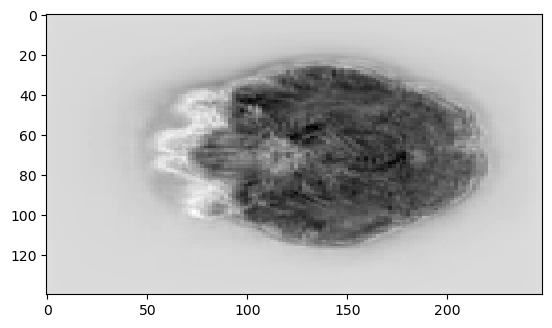

In [247]:
original_shape=(140,248,250)
print(f"Image predict shape: {prediction.shape}")

# Now resize the prediction back to the original NIfTI shape
resized_prediction1 = resize_prediction_to_original_shape(prediction[0, :, :, :, 0], original_shape)  # Remove batch and channel dimensions
print(f"Resized prediction shape: {resized_prediction1.shape}")

# Save the prediction as a new NIfTI file


# Visualize the middle slice
import matplotlib.pyplot as plt
plt.imshow(resized_prediction1[:, :, original_shape[2]//2], cmap='gray')
plt.show()

In [248]:
X_test,y_test=load_3d_data('eval_in/')

In [249]:
model.evaluate(X_test,y_test,batch_size=4)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.9972 - loss: 0.0358


[0.03579453006386757, 0.9971984028816223]

In [250]:
predictiontest=model.predict(X_test[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [251]:
predictiontest.sum()

1042394.06

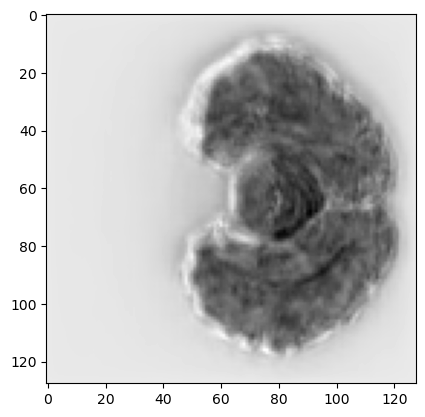

In [252]:
plt.imshow(predictiontest[0, :, :, 64, 0], cmap='gray')
plt.show()

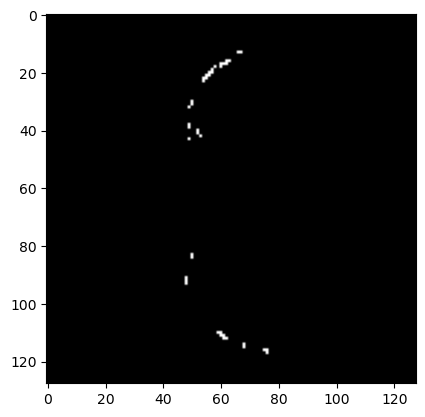

In [253]:
threshold = 0.5
binary_prediction = (predictiontest > threshold).astype(np.uint8)

# Visualize the thresholded output
plt.imshow(binary_prediction[0, :, :, 64, 0], cmap='gray')  # Slice at depth 64
plt.show()


In [254]:
from sklearn.metrics import recall_score

In [255]:
y_true=y_test.flatten()

In [256]:
y_pred=model.predict(X_test,batch_size=4)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step


In [260]:
y_pred=y_pred.flatten()

In [261]:
y_pred.shape

(69206016,)

In [266]:
from sklearn.metrics import recall_score

# Assuming y_true and y_pred are both flattened

# Apply a threshold to the predicted probabilities (e.g., 0.5)
y_pred_binary = (y_pred > 0.45  ).astype(int)  # Convert to 0 or 1 based on the threshold

# Ensure y_true is in the proper binary format (0 or 1)
y_true_binary = y_true.astype(int)  # In case y_true is in a floating-point format, convert it to integer

# Calculate recall score
recall = recall_score(y_true_binary, y_pred_binary)
print(f"Recall: {recall}")


Recall: 1.0


In [267]:
from sklearn.metrics import classification_report

In [269]:
from sklearn.metrics import f1_score

In [274]:
# Try a slightly higher threshold
threshold = 0.5  # Start with the typical 0.5 threshold
y_pred_binary = (y_pred > threshold).astype(int)

# Calculate F1 Score (DSC)
from sklearn.metrics import f1_score
f1 = f1_score(y_true_binary, y_pred_binary,average='micro')
print(f"F1 Score (DSC): {f1}")


F1 Score (DSC): 0.998982776295055


In [275]:
f1 = f1_score(y_true_binary, y_pred_binary,average='binary')
print(f"F1 Score (DSC): {f1}")

F1 Score (DSC): 0.0


In [276]:
def preprocess_image_3d(image):
    # Compute the zoom factors for each dimension (z, y, x)
    zoom_factors = [128 / s for s in image.shape]  # Assumes input is a 3D array (z, y, x)
    
    # Resize the 3D image using zoom
    image = zoom(image, zoom_factors, order=1)  # Order=1 for bilinear interpolation
    
    # Normalize the image (assuming non-zero max)
    image = image / np.max(image) if np.max(image) != 0 else image
    
    # Add batch and channel dimensions (necessary for Keras model)
    image = np.expand_dims(image, axis=(0, -1))  # Shape: (1, z, y, x, 1)
    
    return image

# Function to load a NIfTI image
def load_nifti_image(file_path):
    nifti_image = nib.load(file_path)
    image_data = nifti_image.get_fdata()
    return image_data, nifti_image.affine

# Function to save a NIfTI image
def save_nifti_image(data, affine, output_path):
    nifti_image = nib.Nifti1Image(data, affine)
    nib.save(nifti_image, output_path)
    print(f"Saved NIfTI file at: {output_path}")

# Main function to handle the process
def predict_and_save_nifti(model_path, input_image_path, output_path):
    # Load your trained model
    model = tf.keras.models.load_model(model_path, compile=False)  # Load without compiling
    
    # Load the input 3D image
    image_data, affine = load_nifti_image(input_image_path)
    
    # Preprocess the image
    preprocessed_image = preprocess_image_3d(image_data)
    
    # Make predictions with the model
    prediction = model.predict(preprocessed_image)
    
    # Remove the batch and channel dimensions (get back the original shape)
    prediction = np.squeeze(prediction)
    
    # Save the prediction to a NIfTI file
    save_nifti_image(prediction, affine, output_path)

In [278]:
input_image_path = input("Enter the path to the input 3D NIfTI image (.nii file): ")
output_path = input("Enter the path to save the prediction (.nii file): ")
model_path = input("Enter the path to the trained model (.h5 file): ")
if not os.path.exists(input_image_path):
    print("Input image file does not exist.")
else:
    predict_and_save_nifti(model_path, input_image_path, output_path)

Enter the path to the input 3D NIfTI image (.nii file):  train/flair/1_FLAIR_isovox.nii.gz
Enter the path to save the prediction (.nii file):  predictedflair.nii
Enter the path to the trained model (.h5 file):  model_with_mri.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
Saved NIfTI file at: predictedflair.nii


In [280]:
del model,loaded_model

In [332]:
model3=unet_3d(input_shape_mri)

/home/raneem/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [333]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss=focal_loss(gamma=5, alpha=0.95),  # Experiment with gamma and alpha
    metrics=['accuracy']
)


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step - accuracy: 0.3654 - loss: 0.02


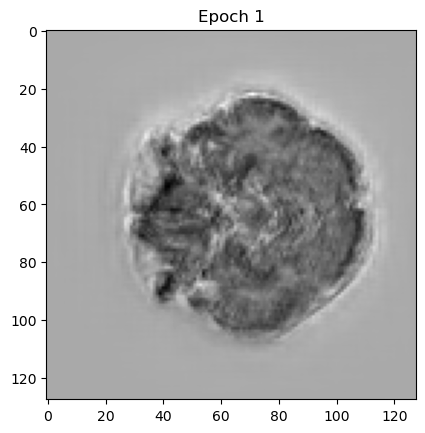

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3746 - loss: 0.0205  
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/stepp - accuracy: 0.6973 - loss: 0.020


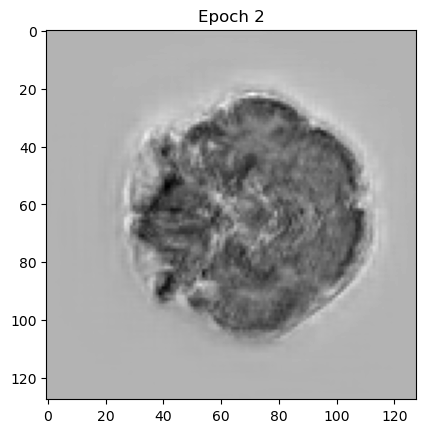

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 782ms/step - accuracy: 0.7011 - loss: 0.0204
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/stepp - accuracy: 0.8620 - loss: 0.020


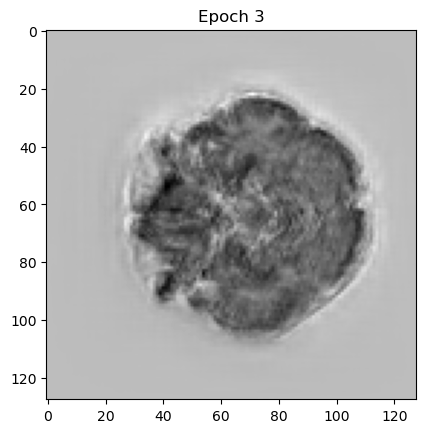

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 831ms/step - accuracy: 0.8640 - loss: 0.0204
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step accuracy: 0.9341 - loss: 0.020


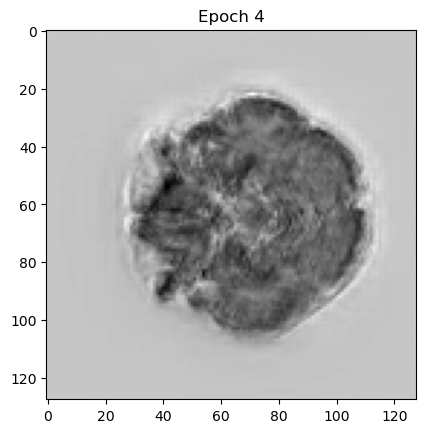

9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9349 - loss: 0.0203
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step accuracy: 0.9618 - loss: 0.020


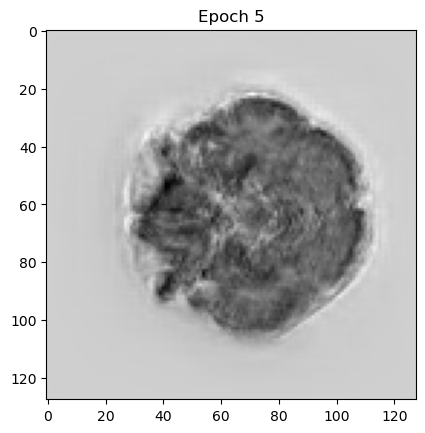

9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.9624 - loss: 0.0203


In [334]:
model3.fit(X_train, y_train, epochs=5, batch_size=4, callbacks=[VisualizePredictionCallback()])

In [351]:
y_pred=model3.predict(X_test,batch_size=4)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step


In [352]:
y_pred_binary = (y_pred > 0.5  ).astype(int)


In [353]:
y_pred_binary.sum()

1424958

In [354]:
y_pred_binary=y_pred_binary.flatten()

In [348]:
y_pred_binary.max()

1

In [355]:
f1 = f1_score(y_true_binary, y_pred_binary,average='micro')
print(f"F1 Score (DSC): {f1}")

F1 Score (DSC): 0.9793941179911295


In [343]:
y_pred.max()

0.5079259